In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter



import warnings
warnings.filterwarnings('ignore') 

In [2]:
zoo = pd.read_csv("C:/Users/DELL/Downloads/assignment/KNN/Zoo.csv")

In [3]:
zoo.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [4]:
zoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  type         101 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


In [5]:
zoo.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000


In [6]:
zoo.duplicated().sum()

0

In [7]:
zoo.shape

(101, 18)

<Axes: >

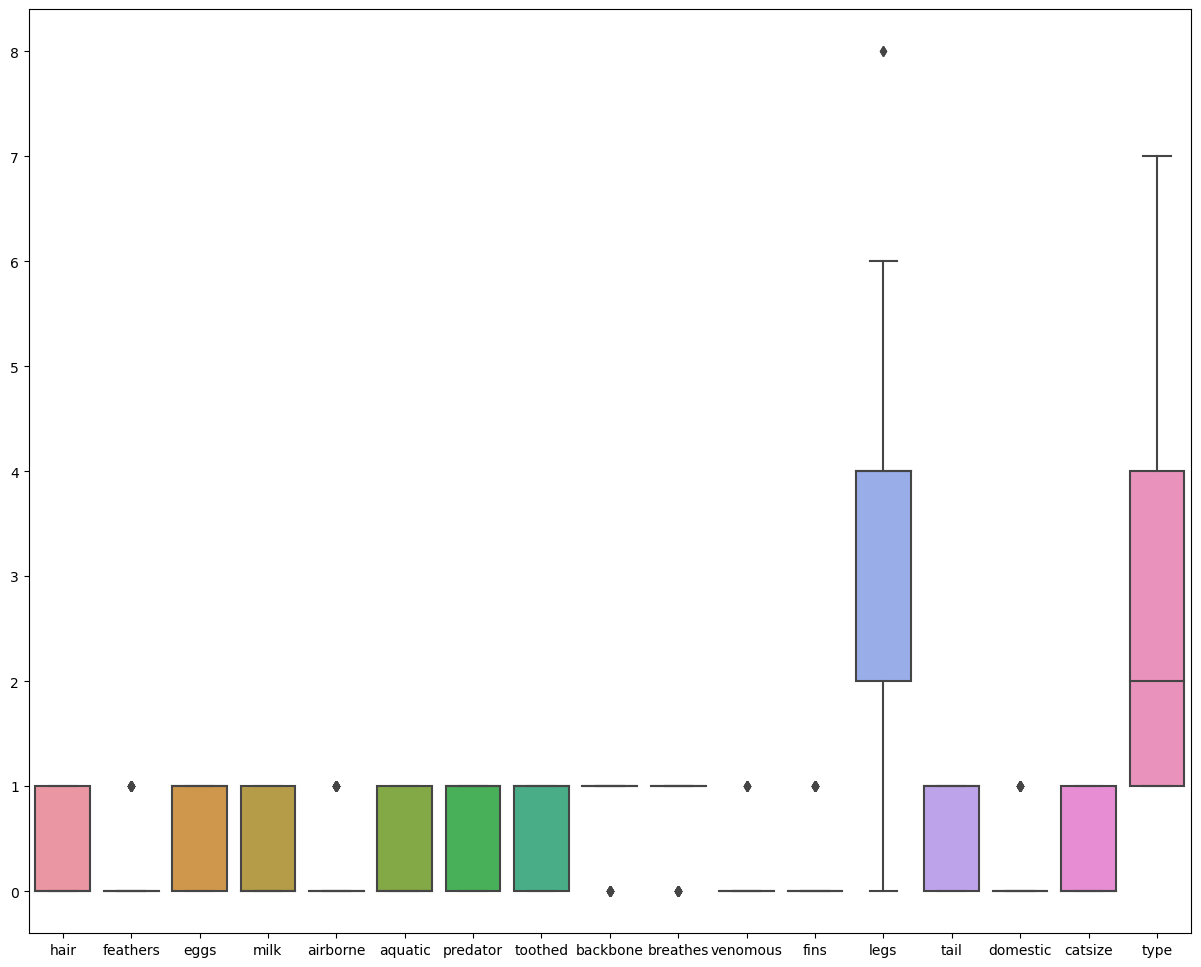

In [8]:
plt.figure(figsize=(15,12))

sns.boxplot(data=zoo)

In [9]:
numerical_features = zoo.describe(include=['int64','float64']).columns
numerical_features

Index(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator',
       'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail',
       'domestic', 'catsize', 'type'],
      dtype='object')

In [10]:
def outlier(zoo):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in zoo.columns.tolist():
        Q1 = np.percentile(zoo[col], 25)
        Q3 = np.percentile(zoo[col],75)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = zoo[(zoo[col] < Q1 - outlier_step) | (zoo[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier(zoo[numerical_features]))))
print(outlier(zoo[numerical_features]))

The dataset contains 10 observations with more than 2 outliers
[11, 20, 57, 39, 97, 53, 72, 77, 7, 86]


# Data Pre-Processing

In [11]:
x=zoo.drop(['type','animal name'],axis=1)
y=zoo[['type']]

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=7)

print('Shape of X_train: ' ,x_train.shape)
print('Shape of X_test: ' , x_test.shape)
print('Shape of y_train: ' ,y_train.shape)
print('Shape of y_test' ,y_test.shape)

Shape of X_train:  (70, 16)
Shape of X_test:  (31, 16)
Shape of y_train:  (70, 1)
Shape of y_test (31, 1)


In [13]:
#lets check with k value 5
num_folds = 10
kfold = KFold(n_splits=10)

In [14]:
model = KNeighborsClassifier(n_neighbors=5)
results = cross_val_score(model, x,y, cv=kfold)
# We are using x,y instead of x_train,y_train because we are using kfold cross validation

In [15]:
print('Accuracy with k = 5 and k fold validation', np.round(results.mean(),3))

Accuracy with k = 5 and k fold validation 0.88


In [16]:
# if you want to use train test split then
model = KNeighborsClassifier(n_neighbors=5) # K = 5
model.fit(x_train,y_train)
pred_y = model.predict(x_test)
accuracy_score(y_test, pred_y)
print('Accuracy with k = 5 and train test split', accuracy_score(y_test, pred_y))

Accuracy with k = 5 and train test split 0.9032258064516129


In [17]:
# using gridsearch to find best k value
n_neigh = np.array(range(1,40,2)) #odd number of k
param_grid = dict(n_neighbors=n_neigh)

In [18]:
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid.fit(x, y) 

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])})

In [19]:
print(grid.best_score_)
print(grid.best_params_) 

0.9800000000000001
{'n_neighbors': 1}


In [20]:
n_neigh = np.array(range(3,40,2)) #odd number of k excluding 1
param_grid = dict(n_neighbors=n_neigh) 

model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid.fit(x, y)  

print(grid.best_score_)
print(grid.best_params_) 

0.9400000000000001
{'n_neighbors': 3}


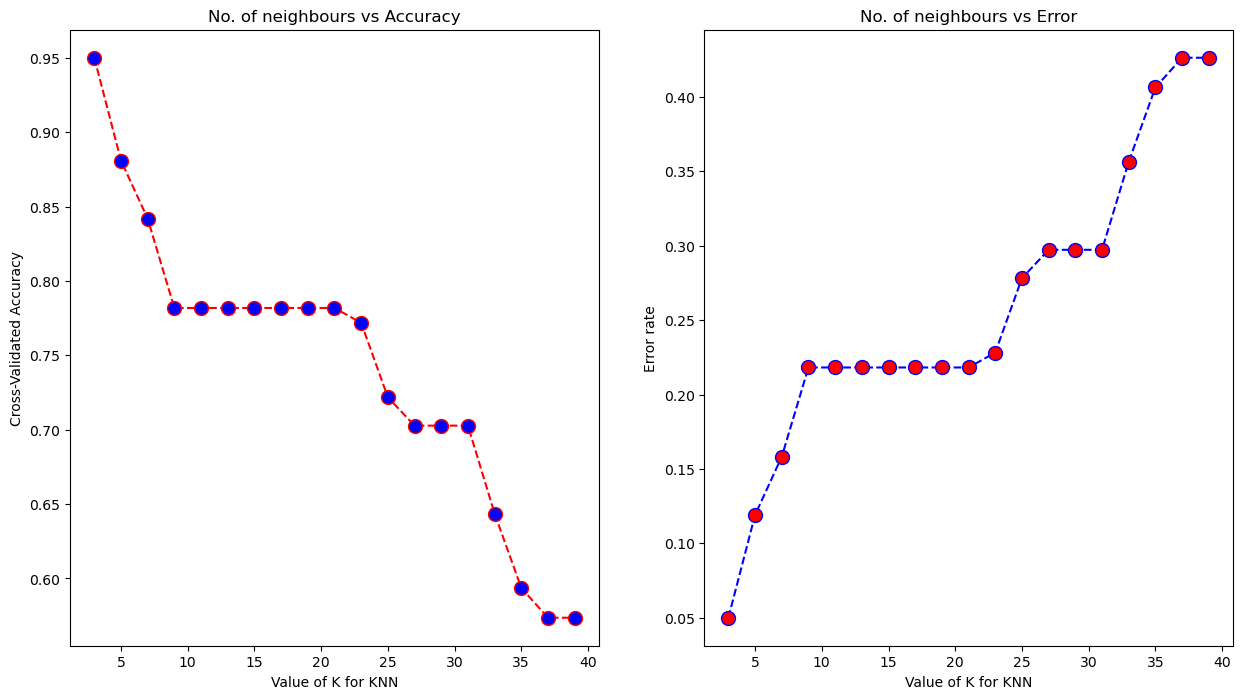

In [21]:
# Visualizing performance against no. of neighbors

import matplotlib.pyplot as plt 
%matplotlib inline

# choose k between 3 to 39
k_range =np.array(range(3,40,2))
k_scores = []
error_rate = []

# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())
    
    error_rate.append((1-scores.mean()))
      

        
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(k_range, k_scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('No. of neighbours vs Accuracy')

plt.subplot(1,2,2)
plt.plot(k_range , error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10) 
plt.xlabel('Value of K for KNN')
plt.ylabel('Error rate')
plt.title('No. of neighbours vs Error')

plt.show() 

In [22]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train, y_train)
pred_y = model.predict(x_test)
accuracy_score(y_test, pred_y)

0.9354838709677419

In [23]:
print(classification_report(y_test, pred_y)) 

              precision    recall  f1-score   support

           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00         5
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         2
           6       0.83      1.00      0.91         5
           7       1.00      0.67      0.80         3

    accuracy                           0.94        31
   macro avg       0.94      0.93      0.93        31
weighted avg       0.95      0.94      0.93        31



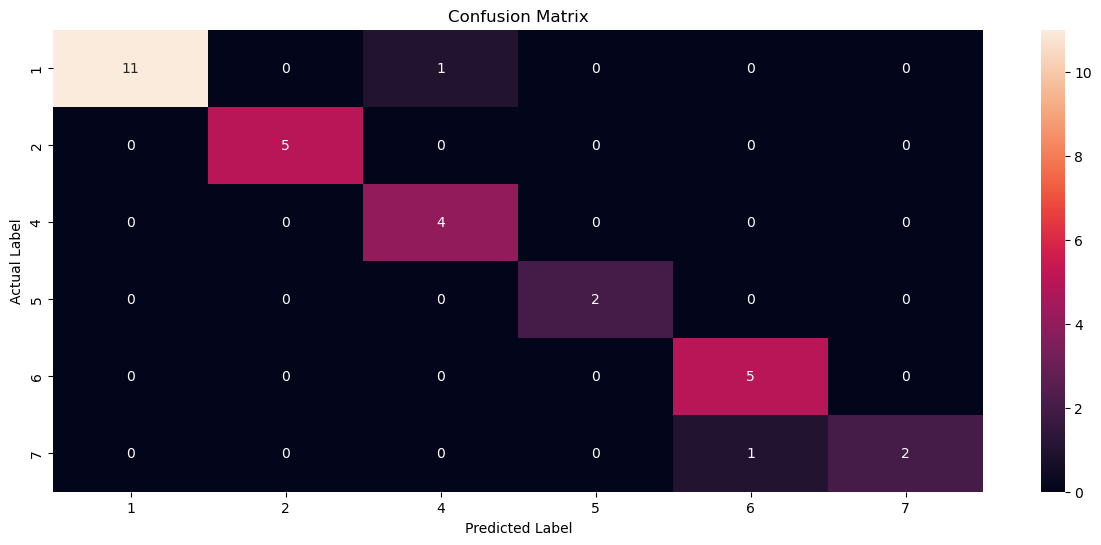

In [24]:


cm_df = confusion_matrix(y_test, pred_y)
class_label = ['1','2','4','5','6','7'] #class 3 is absent in test set

df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)
plt.figure(figsize=(15,6))
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()